### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [464]:
# Imports
# pip install imageio matplotlib scikit-learn
# pip install shapely
import random
import warnings
import time
import numpy as np
import imageio.v3 as iio
import math
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from typing import Optional
from skimage.metrics import structural_similarity
from scipy.ndimage import binary_dilation
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon
from shapely.prepared import prep
from sklearn.metrics.pairwise import euclidean_distances
from collections import OrderedDict
from typing import List
from typing import Tuple
from typing import Callable
from shapely.geometry import Polygon
from shapely.prepared import prep
from numpy.typing import NDArray
from typing import TypeAlias

In [465]:


rng = np.random.default_rng()
NpImageDType = np.float32
NpImage: TypeAlias = NDArray[NpImageDType]
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images
""

''

In [466]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


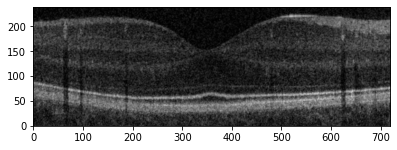

In [467]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [468]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [469]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None, title=None):
        if save is not None:
            plt.savefig(save)
        if title is not None:
            plt.title(title, fontdict={"fontsize": 25, "fontweight": 900})
        plt.show()


In [470]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [471]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

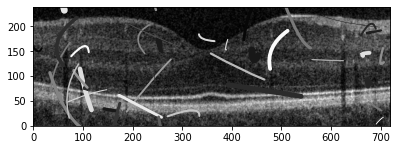

In [472]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

[[200.         180.        ]
 [217.7312124  157.32018935]
 [200.          20.        ]]


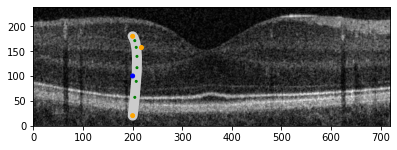

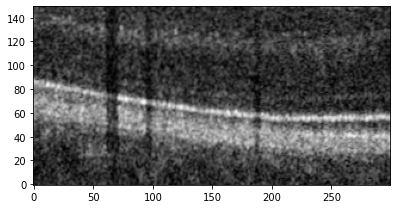

In [473]:
# Draw a single worm along with control points and some sample points

# (x, y, r, theta, deviation_r, deviation_gamma, width, colour)
worm = Camo_Worm(200, 100, 80, np.radians(270), 60, np.pi-0.3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
print(worm.control_points())
drawing.add_dots((200,100), color='blue')
drawing = Drawing(crop(image, [0,150, 0, 300]))

drawing.show(save='bezier.png')

In [474]:
def filter_out_close_points(points, *, point_interval=6):
    """
    Takes in a numpy array of points, and filters out
    all the points that are closer than point_interval
    together. The exception to this is that the first
    and last points are always kept.
    """
    # 1. Calculate the distances between adjacent points.
    n_points = points.shape[0]
    offsets = points[:-1] - points[1:]
    distances = np.sqrt(offsets[:, 0]**2 + offsets[:, 1]**2)
    
    # 2. Adjust the point_interval so we can evenly space the points.
    total_distance = np.sum(distances)
    point_interval = total_distance / math.ceil(total_distance / point_interval)

    # 3. Create an array to use as a filter for the points.
    point_filter = np.zeros(n_points, dtype=bool)  # An array of which points to keep.
    point_filter[0] = True  # The first and last points should always be kept.
    point_filter[n_points - 1] = True

    # 4. Fill in the point filter.
    curr_dist = 0
    for index in range(1, n_points):
        curr_dist += distances[index - 1]
        if curr_dist >= point_interval:
            point_filter[index] = True
            curr_dist = 0

    # 5. Apply the filter
    return points[np.where(point_filter)]

In [475]:
class CircleMask:
    """
    Contains a circular mask.
    """
    cache_size = 100  # Maximum number of cached CircleMasks
    cache = OrderedDict()  # LRU cache

    def __init__(self, radius: float):
        self.radius = radius

        self.width = math.ceil(radius) * 2
        self.topLeft_x = -math.ceil(radius)
        self.topLeft_y = -math.ceil(radius)

        # Removing Jagged Edge
        
        # Initialize empty lists to store the x and y coordinates
        x_coords = []
        y_coords = []
        
        # Iterate over each pixel in the mask
        for i in range(self.width):
            # Calculate the x-coordinate for each column
            x = self.topLeft_x + i
            x_coords.append([x] * self.width)  # Append the x-coordinate for each pixel in the column
        
            # Calculate the y-coordinates for each row
            y_values = [self.topLeft_y + j for j in range(self.width)]
            y_coords.append(y_values)  # Append the y-coordinates for the entire row
        
        # Convert the lists of x and y coordinates into NumPy arrays
        xx = np.array(x_coords)
        yy = np.array(y_coords)
        dist_from_center = np.sqrt(xx ** 2 + yy ** 2)

        sigma = 0.1 * radius  # Adjust sigma for the Gaussian filter
        self.mask = (dist_from_center < radius).astype(float)
        self.mask = gaussian_filter(self.mask, sigma)

    def draw(self, target_mask, x, y):
        x = int(x)
        y = int(y)

        # Calculate the bounds in the target mask to paste the circle.
        target_from_x = max(0, x + self.topLeft_x)
        target_from_y = max(0, y + self.topLeft_y)
        target_to_x = min(target_mask.shape[0] - 1, x + self.topLeft_x + self.width)
        target_to_y = min(target_mask.shape[1] - 1, y + self.topLeft_y + self.width)
        if target_from_x >= target_to_x or target_from_y >= target_to_y:
            return

        # Calculate the bounds in the circle mask to paste.
        circle_from_x = target_from_x - x - self.topLeft_x
        circle_from_y = target_from_y - y - self.topLeft_y
        circle_to_x = target_to_x - x - self.topLeft_x
        circle_to_y = target_to_y - y - self.topLeft_y

        # Add the circle mask into the target mask.
        target_area = target_mask[target_from_x:target_to_x, target_from_y:target_to_y]
        source_area = self.mask[circle_from_x:circle_to_x, circle_from_y:circle_to_y]
        np.maximum(target_area, source_area, out=target_area)


    @staticmethod
    def Caching(radius):
        """
        Tries to find a cached circle that is close in size to radius.
        If one cannot be found, it creates it and caches it.
        """
        # Quantize the radius (if needed)
        quantized_radius = round(radius, 1)  # Quantize to two decimal places (adjust as needed)
    
        # Check if the quantized radius is in the cache
        if quantized_radius in CircleMask.cache:
            # Move the item to the end to mark it as most recently used
            CircleMask.cache.move_to_end(quantized_radius)
            return CircleMask.cache[quantized_radius]
    
        # Create a new circle mask
        mask = CircleMask(quantized_radius)
    
        # Cache the new circle mask
        if len(CircleMask.cache) >= CircleMask.cache_size:
            # If the cache is full, evict the least recently used item
            CircleMask.cache.popitem(last=False)  # Remove the first item
        CircleMask.cache[quantized_radius] = mask
    
        return mask

In [476]:
class WormMask:
    def __init__(self, worm, image: NpImage, *, copy: 'WormMask'=None):
        self.worm = worm
        self.image = image

        if copy is None:
            # Worm Information
            img_width = image.shape[0]
            img_height = image.shape[1]
            radius = worm.width / 2 
            self.points = worm.bezier(np.linspace(0, 1, num=400))
            self.worm_r = worm.r
            self.min_x = max(0, math.floor(np.amin(self.points[:, 1])) - math.ceil(radius*1.5))
            self.min_y = max(0, math.floor(np.amin(self.points[:, 0])) - math.ceil(radius*1.5))
            max_x = min(img_width, math.ceil(np.amax(self.points[:, 1])) + math.ceil(radius*1.5))
            max_y = min(img_height, math.ceil(np.amax(self.points[:, 0])) + math.ceil(radius*1.5))
            width = max_x - self.min_x
            height = max_y - self.min_y

            # If the worm is outside of the image
            if width <= 0 or height <= 0:
                self.min_x = 0
                self.min_y = 0
                self.mask = np.zeros((1, 1))
            else:
                self.points = filter_out_close_points(self.points, point_interval=radius/2)
                self.n_points = self.points.shape[0]  

                # 3. Apply a circle mask at each point on the curve to the mask.
                self.mask = np.zeros((width, height))
                circle_mask = CircleMask.Caching(radius)
                for y, x in self.points:
                    circle_mask.draw(self.mask, x - self.min_x, y - self.min_y)

            self.area = np.sum(self.mask)
            self.width = self.mask.shape[0]
            self.height = self.mask.shape[1]
            self.max_x = self.min_x + self.width
            self.max_y = self.min_y + self.height
        else:
            self.min_x = copy.min_x
            self.min_y = copy.min_y
            self.max_x = copy.max_x
            self.max_y = copy.max_y
            self.width = copy.width
            self.height = copy.height
            self.mask = copy.mask
            


    
    def create_outer_mask(self) -> 'WormMask':
        
        distance = max(1, round(self.worm.width / 2.0))
    
        # Dilate the original mask to create the outer mask
        dilated_mask = binary_dilation(self.mask, iterations=distance)
        # Subtract the original mask to remove the inner worm
        dilated_mask = np.maximum(dilated_mask - self.mask, 0)
        # Create a copy of the existing worm mask
        outer_mask = WormMask(self.worm, self.image, copy=self)
    
        # Update the properties of the outer mask
        outer_mask.min_x -= distance
        outer_mask.min_y -= distance
        outer_mask.max_x += distance
        outer_mask.max_y += distance
        outer_mask.width += 2 * distance
        outer_mask.height += 2 * distance
        outer_mask.mask = np.zeros((outer_mask.width, outer_mask.height))
    
        # Update the outer mask with the dilated mask
        outer_mask.mask[distance:distance+self.width, distance:distance+self.height] = dilated_mask
        # Crop the mask to the bounds of the image.
        min_x = max(0, outer_mask.min_x)
        min_y = max(0, outer_mask.min_y)
        max_x = min(self.image.shape[0], outer_mask.max_x)
        max_y = min(self.image.shape[1], outer_mask.max_y)
    
        # Extract the desired region directly from the mask array.
        outer_mask.mask = outer_mask.mask[min_x - outer_mask.min_x:max_x - outer_mask.min_x, min_y - outer_mask.min_y:max_y - outer_mask.min_y]
    
        outer_mask.min_x = min_x
        outer_mask.min_y = min_y
        outer_mask.max_x = max_x
        outer_mask.max_y = max_y
    
        # Update the dimensions of the mask.
        outer_mask.width = max_x - min_x
        outer_mask.height = max_y - min_y
        # Update the area of the mask.
        outer_mask.area = np.sum(dilated_mask)
        return outer_mask


    def draw_into(self, image, colour):
        """
        Draws this worm mask into the given image with the given colour.
        """
        # 1. Get the subsection that corresponds to the mask.
        image_subsection = image[self.min_x:self.max_x, self.min_y:self.max_y]
        
        # 2. Black-out the area under the mask.
        np.subtract(image_subsection, image_subsection * self.mask, image_subsection)
        
        # 3. Add in the colour for the masked area.
        np.add(image_subsection, colour * self.mask, image_subsection)
        
    def colour_under_points(self, points: np.ndarray, image: NpImage, buckets: int) -> np.ndarray:
        """ Finds the mean colour in the image under the buckets sections of the given points. """
        point_groups = np.array_split(points, buckets)
        colours = np.empty((buckets,), dtype=NpImageDType)
        for group_index, point_group in enumerate(point_groups):
            total = 0
            count = 0  # Count the number of valid points
            for point in point_group:
                # Convert coordinates to integers
                x, y = point.astype(int)
                # Check if the coordinates are within the image bounds
                if 0 <= x < image.shape[0] and 0 <= y < image.shape[1]:
                    total += image[x, y]
                    count += 1
            # Calculate the mean colour only if there are valid points in the group
            colours[group_index] = (total / 255.0) / count if count > 0 else 0
        return colours
    
    def image_within_bounds(self, image=None):
        """
        Returns the image under the mask with the pixels
        not within the mask being marked as 0.
        """
        image = self.image if image is None else image

        # Get the subset of the image corresponding to this mask.
        return image[self.min_x:self.max_x, self.min_y:self.max_y] / 255.0

    def image_under_mask(self, image=None):
        """
        Returns the image under the mask with the pixels
        not within the mask being marked as 0.
        """
        # Apply the mask to the image.
        return self.image_within_bounds(image) * self.mask

    def difference_image(self, image=None):
        """
        This applies this mask to the image, to calculate the differences
        between the colour of the worm and all the pixels beneath the worm.
        """
        # 1. Calculate the difference of the colour of the worm to its background.
        diff_image = np.absolute(self.image_under_mask(image) - self.worm.colour)

        # 2. Apply the mask to the difference.
        return diff_image * self.mask

    @property
    def mean_colour(self):
        """
        Returns the mean colour of all pixels underneath this mask in the image.
        """
        if self.area == 0:
            return None

        return np.sum(self.image_under_mask()) / self.area

    @property
    def mode_colour(self):
        """
        Returns the most common colour of all pixels underneath this mask in the image.
        """
        if self.area == 0:
            return None

        # We want 0 to represent that a pixel is not under the worm.
        sub_image = self.image_within_bounds() + 1
        sub_image = sub_image * self.mask

        colours = np.sort(sub_image.flatten())
        first_index = np.flatnonzero(colours > 0)[0]
        mode_index = math.floor((first_index + len(colours) - 1) / 2.0)
        return colours[mode_index] - 1

    def subsection(self, min_x, min_y, max_x, max_y):
        """
        Gets the subsection of this mask that covers the given coordinates.
        """
        # Check if the specified coordinates are completely outside the bounding box
        if max_x <= self.min_x or max_y <= self.min_y or min_x >= self.max_x or min_y >= self.max_y:
            return None
        
        # Adjust the coordinates to ensure they fall within the bounding box
        min_x = max(self.min_x, min_x)
        min_y = max(self.min_y, min_y)
        max_x = min(self.max_x, max_x)
        max_y = min(self.max_y, max_y)
        
        # Use array slicing to extract the subsection directly, avoiding unnecessary copying
        return self.mask[min_x - self.min_x: max_x - self.min_x, min_y - self.min_y: max_y - self.min_y]
    
    def intersection(self, other: 'WormMask'):
        """
        Calculates the area that intersects between this mask and other.
        """
        sub_self = self.subsection(other.min_x, other.min_y, other.max_x, other.max_y)
        if sub_self is None:
            return 0

        sub_other = other.subsection(self.min_x, self.min_y, self.max_x, self.max_y)
        return 2 * np.sum(np.minimum(sub_self, sub_other)) / max(1, self.area + other.area)

    def midpoint_distance_squared(self, other: 'WormMask'):
        """
        Calculates the distance between the midpoints between this mask and other.
        """
        p1 = self.points[math.floor(len(self.points) / 2)]
        p2 = other.points[math.floor(len(other.points) / 2)]
        return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2




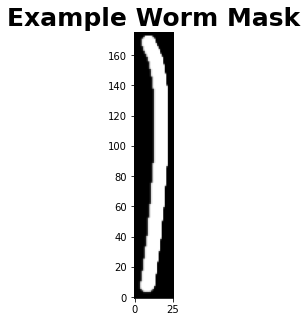

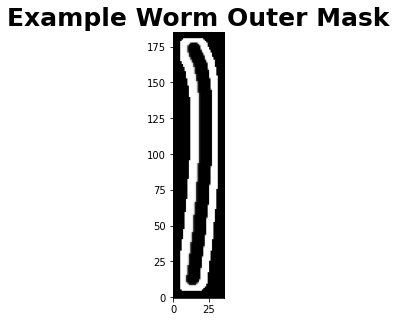

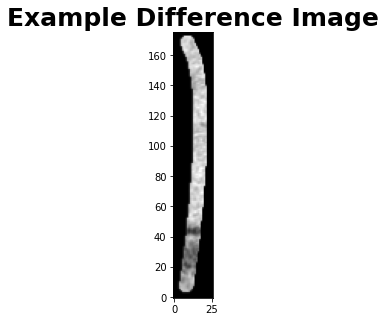

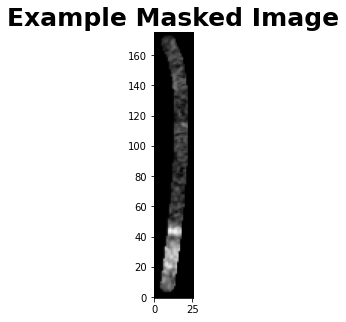

Area = 1550.4, Intersection = 0.1


In [477]:
    # Compare the generated mask with the worm used in the example above.
    worm_mask = WormMask(worm, image)
    Drawing(worm_mask.mask * 255).show(title="Example Worm Mask")
    Drawing(worm_mask.create_outer_mask().mask * 255).show(title="Example Worm Outer Mask")
    Drawing(worm_mask.difference_image() * 255).show(title="Example Difference Image")
    Drawing(worm_mask.image_under_mask() * 255).show(title="Example Masked Image")
    
    example_intersecting_worm = Camo_Worm(200, 100 + 5, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
    intersecting_worm_mask = WormMask(example_intersecting_worm, image)
    print("Area = {:.1f}, Intersection = {:.1f}".format(worm_mask.area, worm_mask.intersection(intersecting_worm_mask)))

In [478]:
def clamp(num, minimum, maximum):
    """
    Returns the closest value to num within the range [minimum, maximum].
    """
    if num < minimum:
        return minimum
    if num > maximum:
        return maximum
    return num

In [479]:
class CostFunction:
    def __init__(self, image, weights):
        self.image = image
        self.weights = weights

    def internal_cost(self, worm):
        ideal_width = 10
        ideal_length = 500
        total_internal_cost = 0
        if worm.colour < 0.06:
            total_internal_cost += 100
        else :
            total_internal_cost += abs(0.5 - worm.colour) * 10

        # Calculate the worm's features
        worm_width = worm.width
        worm_length = worm.approx_length()

        # Encourage worms with ideal width and length
        total_internal_cost += abs(ideal_width - worm_width) / 2.5
        total_internal_cost += abs(ideal_length - worm_length) / 25

        # print("total_internal_cost", total_internal_cost)
        return total_internal_cost

    def fft_magnitudes(self, values: np.ndarray) -> Optional[np.ndarray]:
        if len(values) < 8:
            return None
    
        magnitudes = np.abs(np.fft.rfft(values)[1:])
        magnitudes /= 5
        return magnitudes
        
    def score_worm_considerations_isolated(self, colour: Optional[float], mask: WormMask, outer_mask: WormMask) -> Optional[tuple[float, float, float, float]]:
        if colour is None or mask.area <= 10:
            return None
    
        # Promotes the worms being similar colour to their background.
        body_score = -5 * np.sum(mask.difference_image()**2) / max(1, mask.area)
    
        # Promotes larger good worms.
        # Works against larger bad worms.
        body_score += 0.1
        body_score *= clamp(mask.area, 1, 1200)**0.25
        body_score *= clamp(mask.area - 1200, 1, 1200)**0.2
        body_score -= 0.1
    
        # Promotes the regions outside the worm being dissimilar colour.
        edge_score = np.sum(outer_mask.difference_image()) / max(1, outer_mask.area)
        edge_score *= max(1, outer_mask.area)**0.4
    
        # Promotes consistent colours below the worm.
        colour_fft = self.fft_magnitudes(mask.colour_under_points(mask.points, self.image, 15))
        #print(colour_fft)
        if colour_fft is not None:
            colour_fft -= 0.06
            consistency_score = -np.sum(colour_fft[0:3])
            consistency_score *= max(1.0, 0.01 * mask.area)**0.15
            consistency_score *= max(1.0, 0.1 * mask.worm_r)**0.5
        else:
            # Either tiny or mostly off the image.
            return None
    
        # Promotes smaller worms slightly.
        area_score = -clamp(mask.area / 8000, 0.9, 1) - 0.2 * mask.width**0.5
        # Scale the scores to have approximately a magnitude of 1
        return 0.5 * area_score, body_score, 0.25 * edge_score, 2 * 0# consistency_score


    def score_worm_isolated(self, colour: Optional[float], mask: WormMask, outer_mask: WormMask) -> float:
        """
        Scores the given worm mask based on what is below and around it in the image.
        Does not consider other worms in any clew that the worm is a part of.
        """
        considerations = self.score_worm_considerations_isolated(colour, mask, outer_mask)
        if considerations is None:
            return -999999
    
        area_score, body_score, edge_score, consistency_score = considerations
    
        # We bias the result as we want a score of 0 to represent an okay worm.
        return 0.2 + 2 * area_score + body_score + 6 * edge_score + 0.5 * consistency_score
    
    def coverage_cost (self, worm, clew, clew_masks, *,
            allowed_overlap: float = 0.05, overlap_max_colour_diff: float = 0.4,
            for_new_worm: bool = False) -> float:
        worm_mask = WormMask(worm, image)
        #Drawing(worm_mask.mask * 255).show(title="Example Worm Mask")
        #Drawing(worm_mask.create_outer_mask().mask * 255).show(title="Example Worm Outer Mask")
        #Drawing(worm_mask.difference_image() * 255).show(title="Example Difference Image")
        #Drawing(worm_mask.image_under_mask() * 255).show(title="Example Masked Image")
        score = 50 * self.score_worm_isolated(worm.colour, worm_mask, worm_mask.create_outer_mask())
        #print("score:", score)
        total_coverage_cost = -1*score;
        # Attempts to avoid overlapping and close worms.
        avoid_close = score < 100
        avoid_overlap = True #allowed_overlap < 1
        #print("avoid_close:",avoid_close)
        #print("avoid_overlap:",avoid_overlap)
        #print("avoid_close:",overlap_max_colour_diff)
        #print("avoid_overlap:",allowed_overlap)
        if avoid_close and avoid_overlap:
            close_penalty = 0.0
            overlap_penalty = 0.0
            for other_index in range(len(clew)):
                other_worm = clew[other_index]
                # We don't compare worms that have vastly different colours, as it demotes
                # having worms on the bright and dark sides of an edge.
                if worm is other_worm or abs(worm.colour - other_worm.colour) > overlap_max_colour_diff:
                    continue

                other_worm_mask = clew_masks[other_index]
                if avoid_close:
                    close_penalty += max(0.0, 4000 -
                                         worm_mask.midpoint_distance_squared(other_worm_mask))

                if avoid_overlap:
                    intersection = worm_mask.intersection(other_worm_mask)
                    overlap_penalty += max(0.0, intersection -
                                           allowed_overlap) / (1 - allowed_overlap)

            #print(0.1 * close_penalty + 20 * overlap_penalty)
            total_coverage_cost += 0.2 * close_penalty + 120 * overlap_penalty
        return 0.5 * total_coverage_cost

    def smoothness_cost(self, worm):
        '''
        Considering the worm's curvature and length with respect to 
        the layer changes (i.e., intensity changes).
        '''
        total_smoothness_cost = 0
        detail = 100
        ideal_length = 200
        # ideal_curves = {"no-edge": 200, "slight-edge": 100, "edge": 10}
        path_intensity = [[],[]]

        # Get 100 points along the worm's path
        path = np.array(worm.intermediate_points(detail))
        p0 ,p1 = worm.control_points()[0], worm.control_points()[2]

        # Calculate color adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))
            # Sort intensity at each point
            pixel_colour = self.image[y, x].astype(float) / 255
            path_intensity[1].append([x,y])
            path_intensity[0].append(pixel_colour)

        # Calculate the intesity gradients and magnitudes
        gradients = abs(np.diff(path_intensity[0]))
        edge_point = path_intensity[1][np.argmax(gradients)]
        magnitude = sum(gradients)
        # print("################# NEW WORM #################")
        # print(f"path_intensity:{path_intensity}")
        # print(f"edge_point_index: {edge_point_index}, (x,y) = {path_intensity[1][edge_point_index]}")
        # print(f"gradient:{gradients}")
        # print(f"magnitude:{magnitude}")
        # drawing = Drawing(self.image)
        # drawing.add_worms(worm)
        # drawing.add_dots(worm.control_points(),color='orange')
        # drawing.add_dots(path_intensity[1][edge_point_index],color='blue')
        # drawing.show()

        # Get the worm's features
        worm_curvature = worm.dr
        worm_curve_direct = worm.dgamma
        worm_orientation = worm.theta
        worm_length = worm.approx_length()

        worm_curvature_point = worm.control_points()[1]
        if magnitude >= 2:
            # Large change of intensity, worm is on top of an edge
            total_smoothness_cost += abs(worm_curvature)/magnitude
            total_smoothness_cost += abs(worm_orientation*magnitude) % (2*np.pi)
            total_smoothness_cost += abs(worm_curve_direct*magnitude) % (2*np.pi)
        elif 1 <= magnitude < 2:
            # Slight change in intensity, worm is still on top of an edge
            total_smoothness_cost += abs(worm_curvature_point[0]-edge_point[0])/10
            total_smoothness_cost += abs(worm_curvature_point[1]-edge_point[1])/10
            total_smoothness_cost += abs(worm_orientation/magnitude) % (2*np.pi)
            # total_smoothness_cost += abs(worm_curve_direct/magnitude)
        else:
            # Small or no change in intensity in the worm
            total_smoothness_cost += abs(ideal_length-worm_length)/ideal_length
            total_smoothness_cost += abs(100/worm_curvature)
        # print(f"SMOOTHNESS COST: {total_smoothness_cost}\n")
        return 10 * total_smoothness_cost

    def detail_preservation_cost(self, worm):
        pass

    def colour_adaptation_cost(self, worm):
        # Initialize total colour cost
        total_colour_cost = 0

        # Get all points along the worm's path
        num_points = max(int(worm.approx_length() / (worm.width)), 1)
        path = worm.intermediate_points(num_points)

        # Get worm's colour and width
        colour = worm.colour
        width = int(worm.width)
        checked_points = []
        total_colour_cost_added = 0

        # Calculate colour adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))

            for dx in range(-width, width + 1):
                for dy in range(-width, width + 1):
                    if (dx, dy) not in checked_points:
                        checked_points.append((dx, dy))
                        # Check coordinates are within the image bounds
                        nx = max(0, min(int(x + dx), self.image.shape[1] - 1))
                        ny = max(0, min(int(y + dy), self.image.shape[0] - 1))

                        # Calculate the distance between current point and the worm's closest intermediate point
                        distance = np.sqrt((x - nx) ** 2 + (y - ny) ** 2)

                        # If the distance is less than the worm's width, calculate the color difference
                        if distance <= width:
                            # Calculate colour difference between worm and image at each point
                            image_colour = self.image[ny, nx].astype(float) / 255
                            colour_difference = np.linalg.norm(colour - image_colour)
                            
                            # Accumulate colour adaptation cost
                            total_colour_cost += colour_difference
                            total_colour_cost_added += 1

        # print(f"COLOUR ADAPTATION COST: {50 * total_colour_cost / total_colour_cost_added}\n")
        return 50 * total_colour_cost / total_colour_cost_added

    def efficiency_cost(self, worm):
        pass

    def evaluate(self, worm, clew, clew_masks):
        # Evaluate the total cost
        internal_cost = 0 #self.internal_cost(worm)
        coverage_cost = self.coverage_cost(worm, clew, clew_masks)
        smoothness_cost = 0 #self.smoothness_cost(worm)
        detail_cost = 0 #self.detail_preservation_cost(worm)
        colour_cost = 0 #self.colour_adaptation_cost(worm)
        efficiency_cost = 0 #self.efficiency_cost(worm)

        total_cost = (self.weights['internal'] * internal_cost +
                      self.weights['coverage'] * coverage_cost +
                      self.weights['smoothness'] * smoothness_cost +
                      self.weights['detail'] * detail_cost +
                      self.weights['colour'] * colour_cost +
                      self.weights['efficiency'] * efficiency_cost)

        return total_cost

In [480]:
import random

class GeneticAlgorithm:
    def __init__(self, image, population_size, crossover_rate, mutation_rate, weights):
        self.image = image
        self.population_size = population_size 
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.weights = weights
        self.clew_masks: list[WormMask] = []

    def initialise_population(self, image_shape, init_params):
        population = [random_worm(image_shape, init_params) for _ in range(self.population_size)]
        return population
        
    def select_parents(self, population):
        # Select parents based on fitness
        tournament_size = 5
        parents = []
        for _ in range(self.population_size):
            # ------------ Replace with Different Function------------
            tournament_indices = np.random.choice(range(len(population)), tournament_size, replace=False)
            tournament = [population[i] for i in tournament_indices]
            winner = random.choice(tournament)
            parents.append(winner)
        return parents

    def crossover(self, parent1, parent2):
        # Crossover parents to create offspring
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']

        # Get other parameters from parents
        p1 = np.zeros(len(params))
        p2 = np.zeros(len(params))
        for i, param in enumerate(params):
            if random.random() < self.crossover_rate:
                p1[i] = getattr(parent2, param)
                p2[i] = getattr(parent1, param)
            else:
                p1[i] = getattr(parent1, param)
                p2[i] = getattr(parent2, param)
        
        return p1, p2
    
    
    def mutate(self, worm_params, init_params):
        # Mutate offspring
        # Randomly select any parameters of the worm and mutate it
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
        (radius_std, deviation_std, width_theta) = init_params
        for i, param in enumerate(params):
            if random.random() < self.mutation_rate:
                if param == 'x':
                    worm_params[i] = self.image.shape[1] * rng.random()
                elif param == 'y':
                    worm_params[i] = self.image.shape[0] * rng.random()
                elif param == 'r':
                    worm_params[i] = radius_std * np.abs(rng.standard_normal())
                elif param == 'theta':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'dr':
                    worm_params[i] = deviation_std * np.abs(rng.standard_normal())
                elif param == 'dgamma':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'width':
                    worm_params[i] = width_theta * rng.standard_gamma(3)
                elif param == 'colour':
                    worm_params[i] = rng.random()
        return worm_params
    
    def run(self, max_generations, init_params):
        # Initialize population
        population = self.initialise_population(self.image.shape, init_params)
        cost = CostFunction(image, self.weights)

         # ------------ Add Cost_function to offspring------------
        for generation in range(max_generations):
            # Select parents
            parents = self.select_parents(population)

            # Create offspring through crossover
            offspring = []
            for i in range(0, self.population_size, 2):
                child_param1, child_param2 = self.crossover(parents[i], parents[i+1])
                child_param1= self.mutate(child_param1, init_params)
                child_param2= self.mutate(child_param2, init_params)
                child1 = Camo_Worm(*child_param1)
                child2 = Camo_Worm(*child_param2)
                offspring.extend([child1, child2])
            
            # add parents and offspring together
            new_population = population + offspring
            self.clew_masks = [WormMask(worm, self.image) for worm in new_population]
            # Evaluate the cost of each worm in the new population
            pop_cost = [cost.evaluate(worm, new_population, self.clew_masks) for worm in new_population]
            # Get the indices of worms sorted by their costs in ascending order
            sorted_indices = sorted(range(len(pop_cost)), key=lambda k: pop_cost[k])
            sorted_population = [new_population[i] for i in sorted_indices]

            # Replace old population with new population
            population = sorted_population[:self.population_size]
            total_cost = sum([pop_cost[i] for i in sorted_indices[:self.population_size]])
            if generation % 10 == 0:
                print("total cost of generation", generation, ":", total_cost)
                drawing = Drawing(image)
                for worm in population:
                    drawing.add_worms(worm)
 
        return population

In [481]:
# Define parameters for the Genetic Algorithm
population_size = 50 # Number of worms in the population ---- to be adjusted
crossover_rate = 0.6 # Probability of crossover .6
mutation_rate = 0.4 # Probability of mutation` .4

# Define weights --- to be adjusted/required?
weights = {'internal': 1, 'coverage': 1, 'smoothness': 1, 'detail': 1, 'colour': 1, 'efficiency': 1}

# Create an instance of the GeneticAlgorithm class
genetic_algorithm = GeneticAlgorithm(image, population_size, crossover_rate, mutation_rate, weights)

# Define initial parameters for the worms
init_params = (40, 30, 1)  # Example parameters, adjust as needed

# Define the maximum number of generations
max_generations = 100
clew = genetic_algorithm.run(max_generations, init_params)

# Display the optimized population of worms
drawing = Drawing(image)
for worm in clew:
    drawing.add_worms(worm)


# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Testing cost function for a single worm
# worm_test = Camo_Worm(100, 180, 50, np.pi/6, 70, np.pi/4, 10, 0.6)
# worm_test2 = Camo_Worm(300, 160, 50, np.pi/6, 70, np.pi/4, 8, 0.6)
# test = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
# print(worm_test)
# cost = CostFunction(image, weights)
# c_c = cost.evaluate(worm_test, [worm_test, worm_test2])
# print(c_c)
# drawing.add_worms(worm_test)
# drawing.add_worms(worm_test2)
drawing.show()

# blank drawing
blank_drawing = Drawing(np.full((240, 720), 0, dtype=np.uint8))
for worm in clew:
    blank_drawing.add_worms(worm)
blank_drawing.show()


total cost of generation 0 : 16469.022311747143


In [ ]:
clew_masks = [WormMask(worm, image) for worm in clew]
for print_worm in clew:
    cost = CostFunction(image, weights)
    c_c = cost.evaluate(print_worm, clew, clew_masks)
    print(c_c)

-205.95554186069586
-200.88987827127775
-196.5408681239488
-190.6465450652637
-185.9943059141583
-184.51003577559723
-179.3130624139697
-178.03112247391314
-176.0620307669792
-175.88814338760685
-171.08559101858734
-169.68585937596666
-168.56041417531947
-167.76190626083834
-167.34630406251128
-166.89021606026083
-166.6358693908784
-166.5346831739511
-165.4051656727229
-164.42643885139398
-164.25571051114648
-164.10224263344736
-163.4110353455294
-162.57185719598067
-162.51649464838556
-161.0252902551603
-161.0245819575661
-160.76166937348918
-160.73025097714697
-160.54540664849014
-160.2389026456942
-160.2389026456942
-160.16308069290304
-160.13840961998582
-160.13251428514533
-159.99868917990477
-159.73185958317214
-159.64403892086386
-159.64403892086386
-159.567876112989
-159.5638979655772
-159.4340762555343
-159.11042008729302
-159.08055517664997
-159.01042891427696
-158.96698691934154
-158.76387393180477
-158.74864202329198
-158.6759500599283
-158.6527729960852


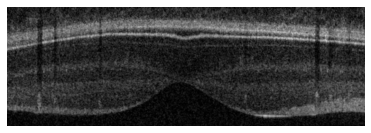

In [ ]:
def display_grayscale_image(color, size=(240, 720)):
    """Display a grayscale image of specified color and size."""
    blank_image = np.full((240, 720), 255, dtype=np.uint8)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')  # Turn off axis
    plt.show()

# Example: Display a white image (255 intensity)
display_grayscale_image(255)  # All white image

&copy; Cara MacNish, UWA, 2024